In [35]:
'''
Imports
'''

proj_dir = '/Users/prabh/200 RESEARCH/Cluster Expansion Project'

# gives the notebook access to the cluster_expansion personal library
from sys import path
path.append(proj_dir)
import cluster_expansion as ce
from cluster_expansion import os, pd, np, plt, sns, tf, Markdown, display, train_test_split

#### Load relevant data, tensors, and models

Data

In [36]:
dir = '../Data/'
sub_dir = 'ChrV/'
file = 'ChrV_M_adapterfree.dat'
dataFilepath = f'{dir}{sub_dir}{file}'

# Read file without treating the first line as a header (most sequence files have no header)
dataArray = pd.read_csv(dataFilepath, header=0, sep = '\t')

try:
  # If there are at least two columns, assume column 1 is c0 and column 0 are sequences
  if dataArray.shape[1] >= 2:
    c0Array = dataArray.iloc[:, 1].values
  else:
    c0Array = None

  seqArray = dataArray.iloc[:, 0].values
  onehotArray = ce.Data2Onehot(seqArray)

except Exception as e:
  print("Error processing data file:", e)
  # Try a fallback: flatten all values to strings and convert to onehot
  try:
    seqs = dataArray.values.ravel().astype(str)
    onehotArray = ce.Data2Onehot(seqs)
    c0Array = None
  except Exception as e2:
    print("Failed to create onehot array:", e2)
    raise

display(dataArray)
display(pd.DataFrame(onehotArray))

Encoded all sequences to onehot


,Sequence,C0free
0,ACTTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTT...,-0.637606
1,CTTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTA...,-0.594615
2,TTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTAT...,-0.559611
3,TACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTATC...,-0.530877
4,ACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTATCC...,-0.515823
...,...,...
571110,CAACAGGGCTTGGAGGAGACGTACATGAGGGCTATTTAGGGCTATT...,1.332731
571111,AACAGGGCTTGGAGGAGACGTACATGAGGGCTATTTAGGGCTATTT...,1.404331
571112,ACAGGGCTTGGAGGAGACGTACATGAGGGCTATTTAGGGCTATTTA...,1.494469
571113,CAGGGCTTGGAGGAGACGTACATGAGGGCTATTTAGGGCTATTTAG...,1.516375


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,0,1,0,0,0,1,...,1,0,0,0,1,0,0,1,0,0
2,0,1,0,0,0,1,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571110,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
571111,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
571112,1,0,0,0,0,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
571113,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0


Tensors

In [39]:
seqs = '100M'
tensor_dir = f'../InteractionTensors/{seqs} Sequences/Symmetric'
consolidated = False

if consolidated:
  W = np.zeros((200))
  J = np.load(f'{tensor_dir}/JC_{seqs}.npy')
  G = np.load(f'{tensor_dir}/GC_{seqs}.npy')
else:
  W = np.load(f'{tensor_dir}/W_{seqs}.npy')
  J = np.load(f'{tensor_dir}/J_{seqs}.npy')
  G = np.load(f'{tensor_dir}/G_{seqs}.npy')

CNN model

In [40]:
# load in CNN model used to generate the sequences that the tensors were trained on

dir = "../CNN_models/"
sub_dir = "RC_invariant/Symmetric/"
model = "S_C0freeAvg"
model_path = f'{dir}{sub_dir}{model}.keras'

try:
    model = tf.keras.models.load_model(model_path)
except Exception as e:
    print('Error:')
    print(e)

#### Predicting C0

In [42]:
c0Array_ML = model.predict(onehotArray).ravel()

print(f"Average C0: {np.mean(c0Array_ML):.2f}")

17848/17848 ━━━━━━━━━━━━━━━━━━━━ 130s 7ms/step
Average C0: -0.23


In [43]:
c0Array_CE = ce.predictArrayC0(onehotArray.reshape(-1, 200), avgC0 = np.mean(c0Array), avgFreq = onehotArray.mean(axis=0), W = W, J = J, G = G)
print(f"Average C0: {np.mean(c0Array_CE):.2f}")

Average C0: -0.27


#### Plotting

r = 0.8366, [-0.0008, 0.0008] (for 95% CI)
r = 0.98155, [-0.00010, 0.00009] (for 95% CI)


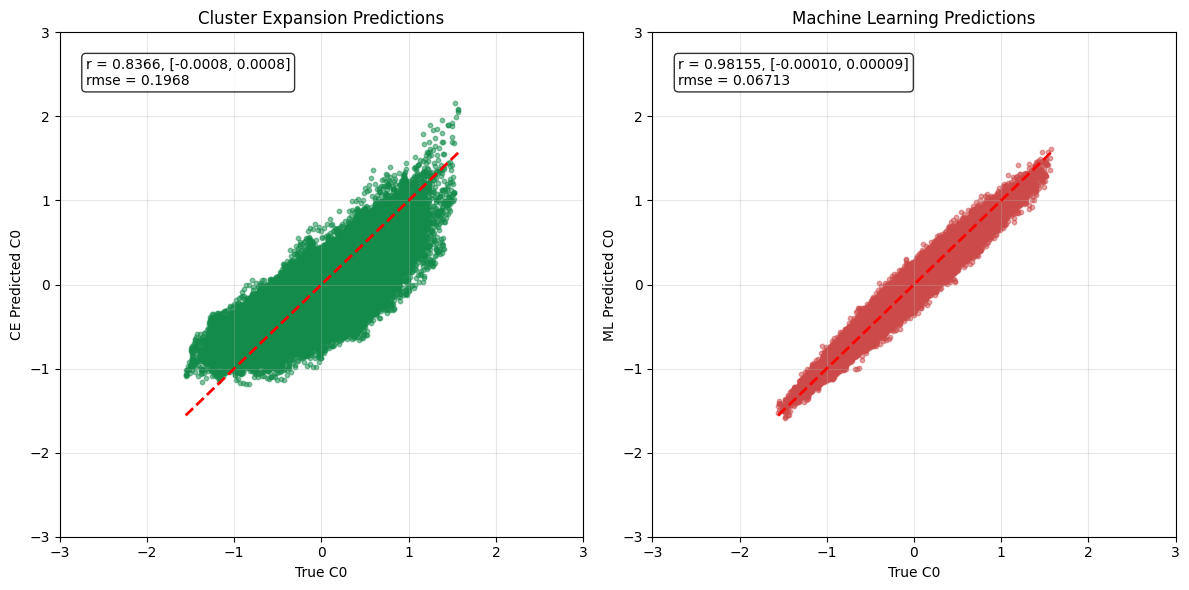

In [44]:
try:
  n = len(c0Array)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

  # Determine pearson r (unpack as: r, se_z, precision, d_low, d_high)
  r_ce, se_z_ce, prec_ce, d_low_ce, d_high_ce = ce.pearson(c0Array, c0Array_CE, ci_int = 0.95, out = True)
  rmse_ce = np.sqrt(np.mean((c0Array_CE - c0Array)**2))

  # CE predictions plot
  ax1.scatter(c0Array, c0Array_CE, s=10, alpha=0.5, color='#138B4B')
  ax1.plot([c0Array.min(), c0Array.max()], [c0Array.min(), c0Array.max()], 'r--', lw=2)
  ax1.set_xlabel('True C0')
  ax1.set_ylabel('CE Predicted C0')
  ax1.set_title('Cluster Expansion Predictions')
  ax1.grid(True, alpha=0.3)
  ax1.set_xlim(-3, 3)
  ax1.set_ylim(-3, 3)

  ax1.text(0.05, 0.95, f'r = {r_ce:.{prec_ce}f}, [{d_low_ce:.{prec_ce}f}, {d_high_ce:.{prec_ce}f}]\nrmse = {rmse_ce:.{prec_ce}f}', 
    transform=ax1.transAxes, verticalalignment='top', 
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

  # Determine pearson r for ML
  r_ml, se_z_ml, prec_ml, d_low_ml, d_high_ml = ce.pearson(c0Array, c0Array_ML, ci_int = 0.95, out = True)
  rmse_ml = np.sqrt(np.mean((c0Array_ML - c0Array)**2))

  # ML predictions plot
  ax2.scatter(c0Array, c0Array_ML, s=10, alpha=0.5, color='#CD4A4A')
  ax2.plot([c0Array.min(), c0Array.max()], [c0Array.min(), c0Array.max()], 'r--', lw=2)
  ax2.set_xlabel('True C0')
  ax2.set_ylabel('ML Predicted C0')
  ax2.set_title('Machine Learning Predictions')
  ax2.grid(True, alpha=0.3)
  ax2.set_xlim(-3, 3)
  ax2.set_ylim(-3, 3)
  ax2.text(0.05, 0.95, f'r = {r_ml:.{prec_ml}f}, [{d_low_ml:.{prec_ml}f}, {d_high_ml:.{prec_ml}f}]\nrmse = {rmse_ml:.{prec_ml}f}', 
    transform=ax2.transAxes, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

  plt.tight_layout()
  plt.show()

except Exception as e:
  print(e)
  print("True c0 values not provided - see next cell of predictive c0 analysis")

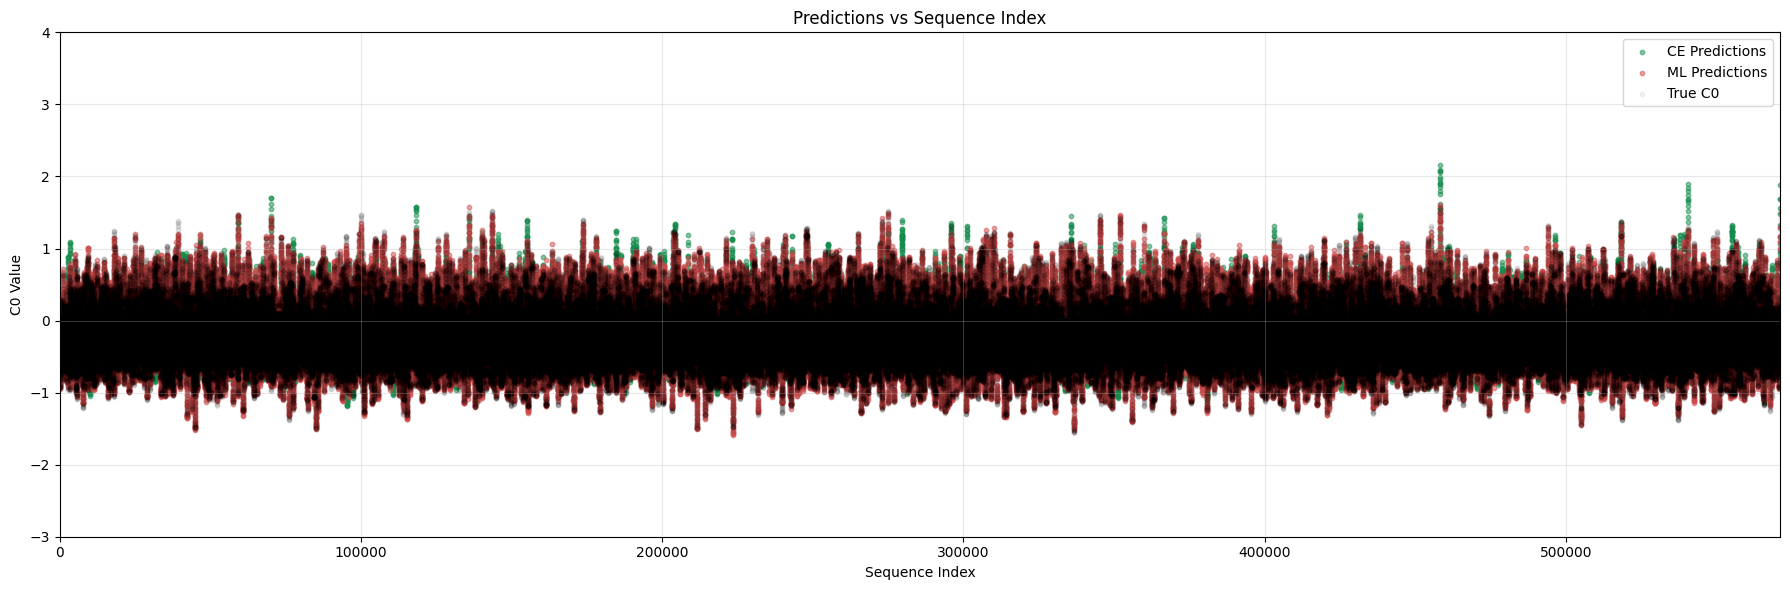

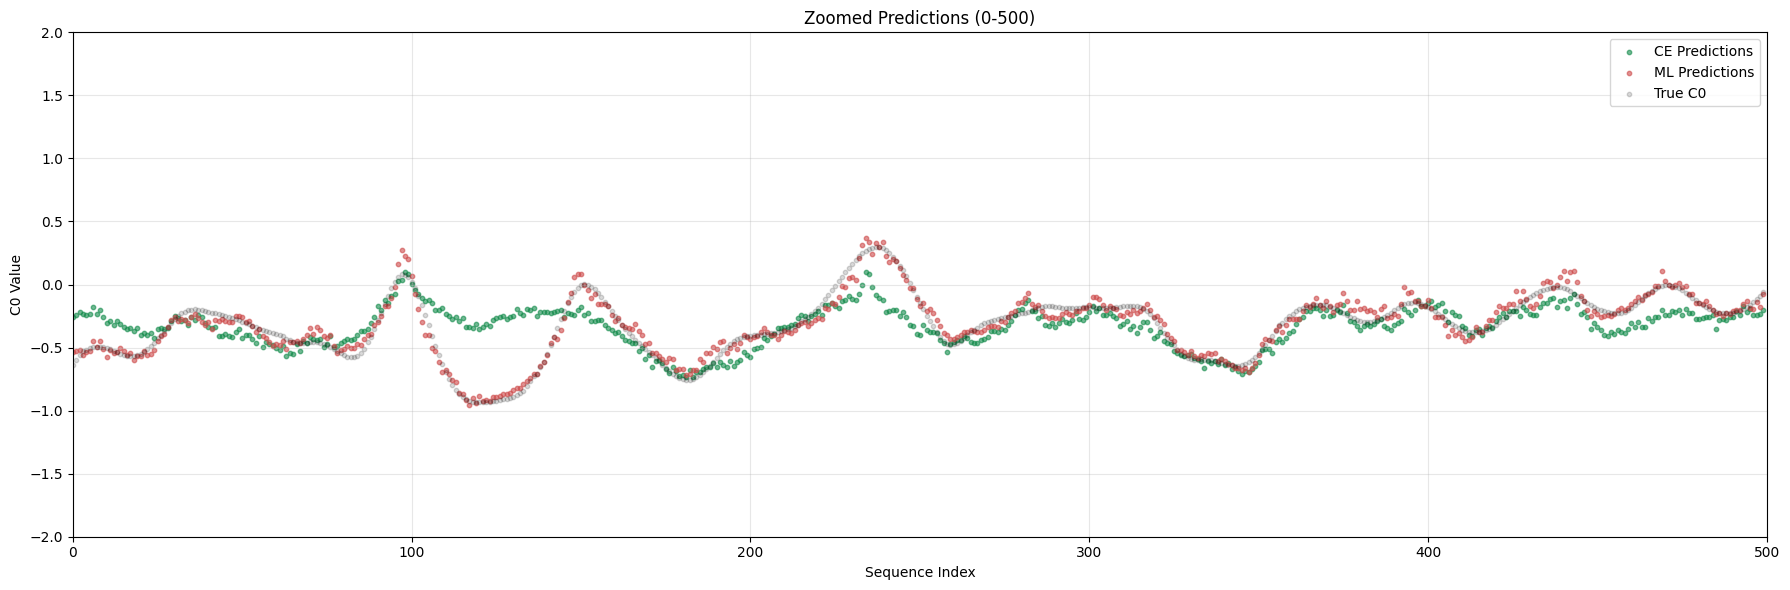

In [45]:
try:
  fig, ax = plt.subplots(1, 1, figsize=(18, 6))

  # Plot predictions
  indices = np.arange(len(c0Array))
  ax.scatter(indices, c0Array_CE, s=10, label='CE Predictions', alpha = 0.5, color='#138B4B')
  ax.scatter(indices, c0Array_ML, s=10, label='ML Predictions', alpha = 0.5, color='#CD4A4A')
  ax.scatter(indices, c0Array, alpha=0.05, s=10, label='True C0', color='black')

  ax.set_xlabel('Sequence Index')
  ax.set_ylabel('C0 Value')
  ax.set_title('Predictions vs Sequence Index')
  ax.legend()
  ax.grid(True, alpha=0.3)

  plt.xlim(-1, len(c0Array))
  ymin = min(np.min(c0Array_CE), np.min(c0Array_ML))
  ymax = max(np.max(c0Array_CE), np.max(c0Array_ML))
  plt.ylim(np.floor(ymin-1), np.ceil(ymax+1))

  plt.tight_layout()
  plt.show()

  # Zoomed view: indices 0-500
  end = min(500, len(indices))
  fig2, ax2 = plt.subplots(1, 1, figsize=(18, 6))
  sub_idx = indices[:end]

  ax2.scatter(sub_idx, c0Array_CE[:end], s=10, label='CE Predictions', alpha=0.6, color='#138B4B')
  ax2.scatter(sub_idx, c0Array_ML[:end], s=10, label='ML Predictions', alpha=0.6, color='#CD4A4A')
  ax2.scatter(sub_idx, c0Array[:end], s=10, label='True C0', alpha=0.15, color='black')

  ax2.set_xlim(0, 500)
  ax2.set_xlabel('Sequence Index')
  ax2.set_ylabel('C0 Value')
  ax2.set_title('Zoomed Predictions (0-500)')
  ax2.legend()
  ax2.grid(True, alpha=0.3)
  plt.ylim(np.floor(min(np.min(c0Array_CE[:end]), np.min(c0Array_ML[:end]), np.min(c0Array[:end])) - 1),
       np.ceil(max(np.max(c0Array_CE[:end]), np.max(c0Array_ML[:end]), np.max(c0Array[:end])) + 1))
  plt.tight_layout()
  plt.show()

except Exception as e:
  print(e)
  print("True c0 values not provided")
  
  # Close previous figure
  plt.close(fig)


  fig, ax = plt.subplots(1, 1, figsize=(18, 6))

  # Plot predictions
  indices = np.arange(len(c0Array_CE))
  ax.scatter(indices, c0Array_CE, s=10, label='CE Predictions', alpha = 0.5, color='#138B4B')
  ax.scatter(indices, c0Array_ML, s=10, label='ML Predictions', alpha = 0.5, color='#CD4A4A')

  ax.set_xlabel('Sequence Index')
  ax.set_ylabel('C0 Value')
  ax.set_title(f'Predictions on {file}')
  ax.legend()
  ax.grid(True, alpha=0.3)

  plt.xlim(-1, len(c0Array_CE))
  plt.xticks(np.arange(0, len(c0Array_CE), max(1, len(c0Array_CE)//10)))
  plt.ylim(np.floor(min(np.min(c0Array_CE), np.min(c0Array_ML)) - 1), np.ceil(max(np.max(c0Array_CE), np.max(c0Array_ML))+1))

  plt.tight_layout()
  plt.show()
